# 🌳 Random Forest Classification

## ⬇️ Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support, f1_score
from sklearn.ensemble import RandomForestClassifier
import os
import sys
import optuna
import optuna.visualization.matplotlib as vis

sys.path.append(os.path.abspath(".."))

from base_preprocessing import BasePreprocessing
from tfidf_preprocessing import TFIDFPreprocessing

## ⭐ Base Preprocessing

In [2]:
if not os.path.exists("../../data/preprocessed_recipe.csv"):
    base_preprocessor = BasePreprocessing()
    raw_data = base_preprocessor.load('../../data/RAW_recipes.csv')
    data = base_preprocessor.transform(raw_data)
    data.to_csv("../../data/preprocessed_recipe.csv")
else:
    data = pd.read_csv("../../data/preprocessed_recipe.csv")
data.head()

,Unnamed: 0,id,name,minutes,n_steps,description,n_ingredients,steps_string_standardize,ingredients_text,tags_text,cuisine,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,0,137739,arriba baked squash mexican,55,11,autumn is my favorite time of year to cook! th...,7,make a choic and proceed with recip depend on ...,"['winter squash', 'mexican seasoning', 'mixed ...","['60-minutes-or-less', 'time-to-make', 'course...",North America – United States,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,1,31490,breakfast pizza,30,9,this recipe calls for the crust to be prebaked...,6,preheat oven to 103.33 celsius °c press dough ...,"['prepared pizza crust', 'sausage patty', 'egg...","['30-minutes-or-less', 'time-to-make', 'course...",North America – United States,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,4,44061,amish tomato ketchup canning,190,5,my dh's amish mother raised him on this recipe...,8,"mix all ingredients& boil for 2 30.0 minute , ...","['tomato juice', 'apple cider vinegar', 'sugar...","['weeknight', 'time-to-make', 'course', 'main-...",North America – United States,352.9,1.0,337.0,23.0,3.0,0.0,28.0
3,5,25274,marinated olive,15,4,my italian mil was thoroughly impressed by my ...,9,toast the fennel seed and lightli crush them p...,"['fennel seeds', 'green olives', 'ripe olives'...","['15-minutes-or-less', 'time-to-make', 'course...",North America – United States,380.7,53.0,7.0,24.0,6.0,24.0,6.0
4,6,67888,barbecued rib,120,10,this recipe is posted by request and was origi...,22,in a medium saucepan combin all the ingredi fo...,"['pork spareribs', 'soy sauce', 'fresh garlic'...","['weeknight', 'time-to-make', 'course', 'main-...",North America – United States,1109.5,83.0,378.0,275.0,96.0,86.0,36.0


## 🛠️ With TFIDFPreprocessing

In [3]:
preprocessor = TFIDFPreprocessing(step_max_features=200, ingredients_max_features=200)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
X_train, y_train = preprocessor.fit_transform(train_data)
X_test, y_test = preprocessor.transform(test_data)

In [4]:
X_train.shape

(64480, 402)

### 🧠 Model

### Grid Search with Optuna

In [5]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 5, 50),
        "max_depth": trial.suggest_int("max_depth", 2, 30),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestClassifier(**params, max_features=None, bootstrap=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-05-06 15:55:26,137] A new study created in memory with name: no-name-4c686ba2-acd9-45e8-b18b-6bac96a8acda
[I 2025-05-06 15:55:27,652] Trial 0 finished with value: 0.16221979934933478 and parameters: {'n_estimators': 10, 'max_depth': 17, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.16221979934933478.
[I 2025-05-06 15:55:30,026] Trial 1 finished with value: 0.09196933578043369 and parameters: {'n_estimators': 35, 'max_depth': 11, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.16221979934933478.
[I 2025-05-06 15:55:31,904] Trial 2 finished with value: 0.16965946319299688 and parameters: {'n_estimators': 13, 'max_depth': 17, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. Best is trial 2 with value: 0.16965946319299688.
[I 2025-05-06 15:55:34,247] Trial 3 finished with value: 0.10573346875483876 and parameters: {'n_estimators': 50, 'max_depth': 8, 'max_features

### Hyperparams

Best parameters: {'n_estimators': 20, 'max_depth': 27, 'max_features': None, 'bootstrap': True, 'criterion': 'log_loss'}
Best f1: 0.22613290726450164


/tmp/nix-shell-2620309-0/ipykernel_3333531/3082113540.py:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  vis.plot_optimization_history(study)


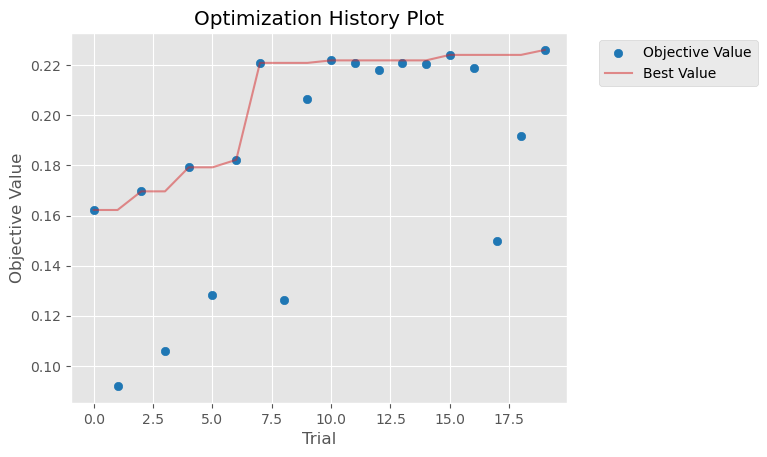

/tmp/nix-shell-2620309-0/ipykernel_3333531/3082113540.py:9: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  vis.plot_param_importances(study)


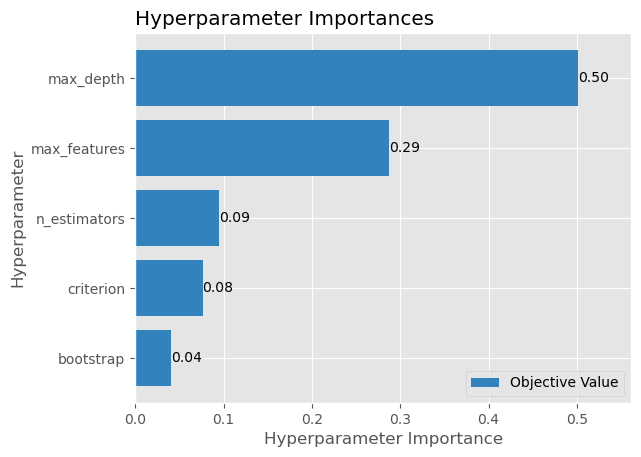

/tmp/nix-shell-2620309-0/ipykernel_3333531/3082113540.py:12: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  vis.plot_slice(study)


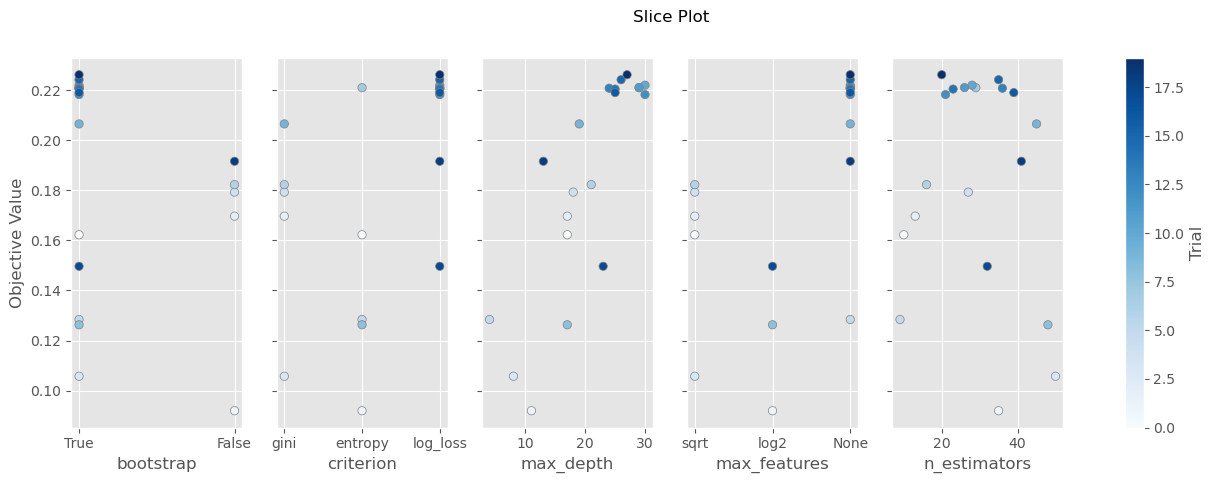

/tmp/nix-shell-2620309-0/ipykernel_3333531/3082113540.py:15: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  vis.plot_parallel_coordinate(study)


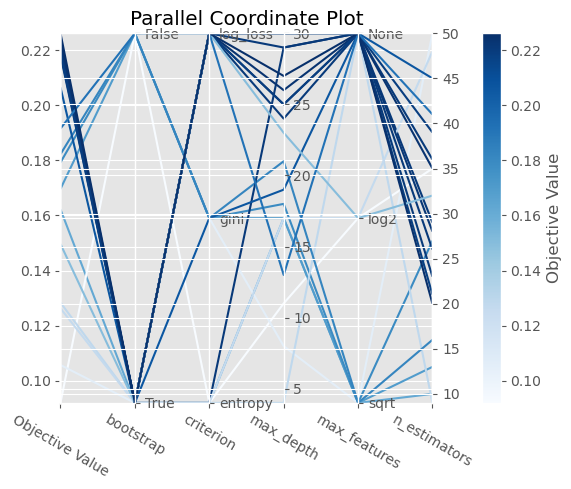

In [6]:
# Print best trial results
print("Best parameters:", study.best_params)
print("Best f1:", study.best_value)

# === Matplotlib Visualizations ===
vis.plot_optimization_history(study)
plt.show()

vis.plot_param_importances(study)
plt.show()

vis.plot_slice(study)
plt.show()

vis.plot_parallel_coordinate(study)
plt.show()

#### Training

In [4]:
print("\nTraining Random Forest Classifier...")

best_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)


Training Random Forest Classifier...


RandomForestClassifier(n_jobs=-1, random_state=42)

#### 📊 Evaluation

In [5]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

print(f"\nMicro-average precision: {precision:.4f}")
print(f"Micro-average recall: {recall:.4f}")
print(f"Micro-average F1-score: {f1:.4f}")

Accuracy: 0.6613

Micro-average precision: 0.6613
Micro-average recall: 0.6613
Micro-average F1-score: 0.6613


In [6]:
print(classification_report(y_test, y_pred, target_names=preprocessor.label_encoder.classes_))

                               precision    recall  f1-score   support

                  Asia – East       0.62      0.29      0.40       533
               Asia – General       0.62      0.65      0.63      1474
                 Asia – South       0.00      0.00      0.00        26
             Asia – Southeast       0.50      0.01      0.02       109
  Central America & Caribbean       0.00      0.00      0.00       111
             Europe – Eastern       0.00      0.00      0.00       136
             Europe – General       0.69      0.19      0.30      1285
            Europe – Northern       0.00      0.00      0.00       160
             Europe – Western       0.63      0.36      0.46      2682
              Jewish Diaspora       0.00      0.00      0.00        88
   Middle East & North Africa       0.79      0.22      0.35       552
North America – United States       0.67      0.94      0.78      8722
            Oceania & Pacific       0.00      0.00      0.00        38
     

/nix/store/79zs2ym85hhnqnmf9ls5kl2rqwmbs0gm-python3-3.11.8-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nix/store/79zs2ym85hhnqnmf9ls5kl2rqwmbs0gm-python3-3.11.8-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nix/store/79zs2ym85hhnqnmf9ls5kl2rqwmbs0gm-python3-3.11.8-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

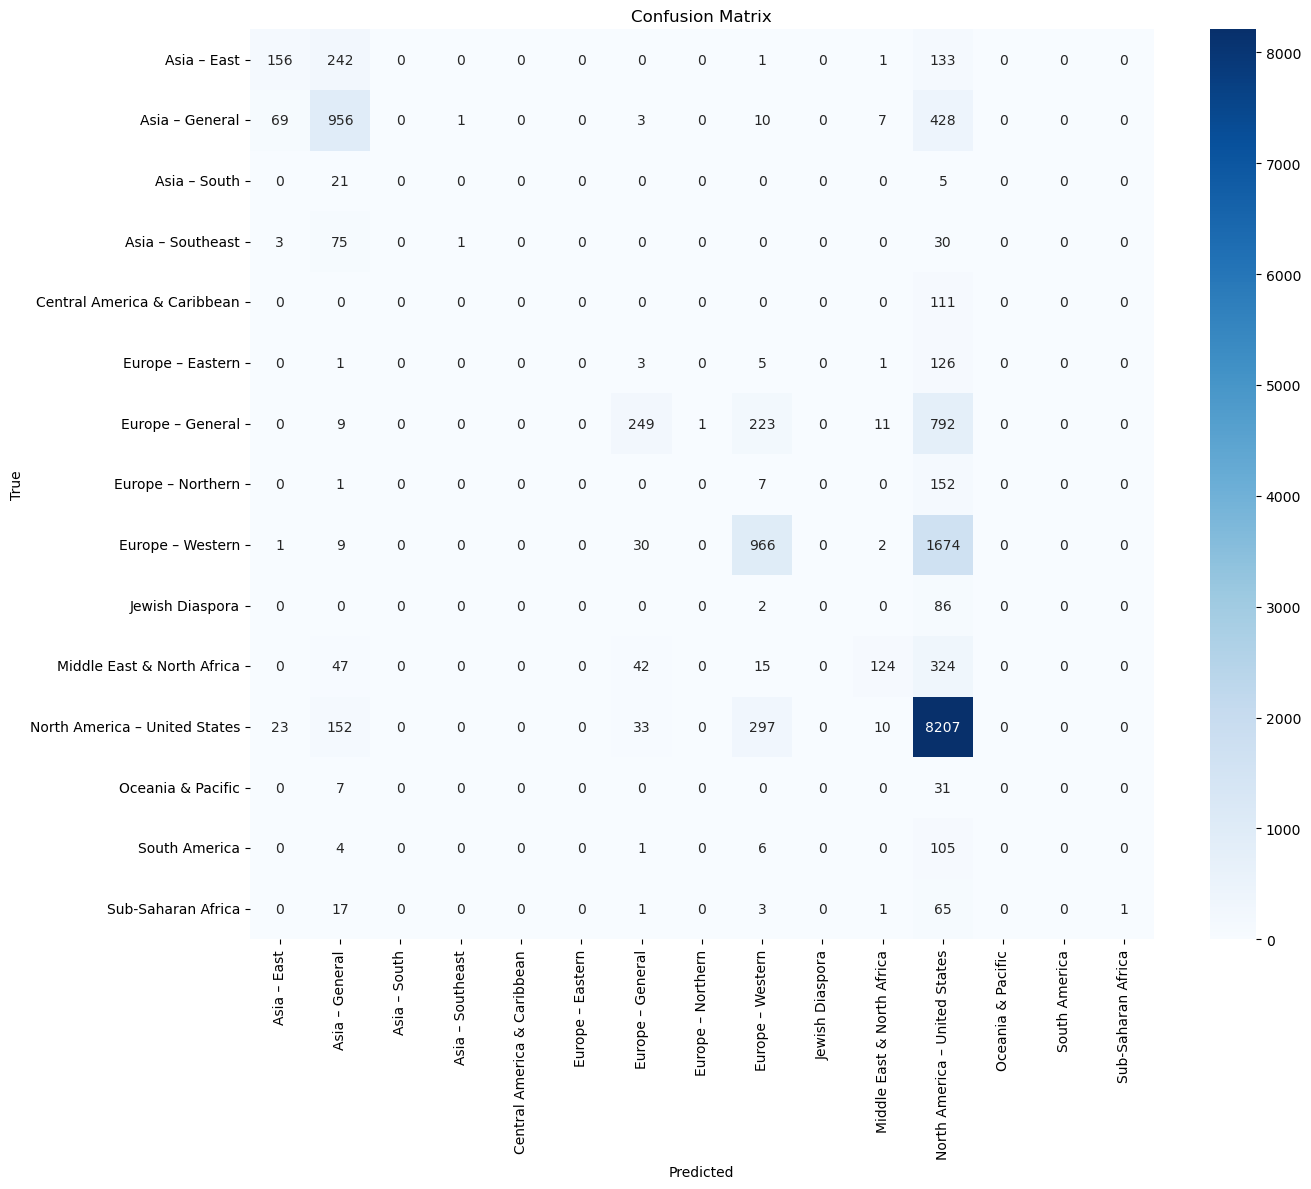

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=preprocessor.label_encoder.classes_, yticklabels=preprocessor.label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [15]:
def predict_cuisine(model, steps_vec, ingredients_vec, recipe_steps, recipe_ingredients, n_steps, n_ingredients, label_encoder, top_n=3):
    """
    Predict top N cuisine types for a new recipe with probabilities
    
    Parameters:
    -----------
    model: trained classifier model
    steps_vec: fitted TF-IDF vectorizer for steps
    ingredients_vec: fitted TF-IDF vectorizer for ingredients
    recipe_steps: list of recipe steps
    recipe_ingredients: list of recipe ingredients
    n_steps: number of steps
    n_ingredients: number of ingredients
    label_encoder: fitted label encoder
    top_n: number of top predictions to return (default: 3)
    
    Returns:
    --------
    list of tuples (cuisine, probability) for top N predictions
    """
    # Prepare steps and ingredients text
    steps_text = ' '.join(recipe_steps)
    ingredients_text = ' '.join(recipe_ingredients)
    
    # Transform text data
    steps_features = steps_vec.transform([steps_text]).toarray()
    ingredients_features = ingredients_vec.transform([ingredients_text]).toarray()
    
    # Create token statistics
    tokens = [token for token in steps_text.split()]
    #token_count = len(tokens)
    #avg_token_length = np.mean([len(token) for token in tokens]) if tokens else 0
    
    # Combine all features
    numerical_features = np.array([[n_steps, n_ingredients]])
    X_new = np.hstack([steps_features, ingredients_features, numerical_features])
    
    # Get probability predictions for all classes
    proba = model.predict_proba(X_new)[0]
    
    # Get indices of top N predictions in descending order of probability
    top_indices = proba.argsort()[-top_n:][::-1]
    
    # Map indices to cuisine names and create (cuisine, probability) tuples
    top_predictions = []
    for idx in top_indices:
        cuisine = label_encoder.inverse_transform([idx])[0]
        probability = proba[idx]
        top_predictions.append((cuisine, probability))
    
    return top_predictions

# Test with sample recipes
print("\n===== Testing with sample recipes =====")

# Sample recipe 1
sample_recipe = data.iloc[30]
top_predictions = predict_cuisine(
    model, steps_vectorizer, ingredients_vectorizer,
    sample_recipe['steps'], sample_recipe['ingredients'],
    sample_recipe['n_steps'], sample_recipe['n_ingredients'],
    label_encoder
)

print(f"\nSample Recipe #1: {sample_recipe['name']}")
print(f"Actual cuisine: {' '.join(sample_recipe['cuisines'])}")
print("Top 3 predicted cuisines:")
for i, (cuisine, prob) in enumerate(top_predictions, 1):
    print(f"  {i}. {cuisine} (probability: {prob:.4f})")

# Sample recipe 2
sample_recipe = data.iloc[20]
top_predictions = predict_cuisine(
    model, steps_vectorizer, ingredients_vectorizer,
    sample_recipe['steps'], sample_recipe['ingredients'],
    sample_recipe['n_steps'], sample_recipe['n_ingredients'],
    label_encoder
)

print(f"\nSample Recipe #2: {sample_recipe['name']}")
print(f"Actual cuisine: {' '.join(sample_recipe['cuisines'])}")
print("Top 3 predicted cuisines:")
for i, (cuisine, prob) in enumerate(top_predictions, 1):
    print(f"  {i}. {cuisine} (probability: {prob:.4f})")

# Try one more sample
sample_recipe = data.iloc[1000]
top_predictions = predict_cuisine(
    model, steps_vectorizer, ingredients_vectorizer,
    sample_recipe['steps'], sample_recipe['ingredients'],
    sample_recipe['n_steps'], sample_recipe['n_ingredients'],
    label_encoder
)

print(f"\nSample Recipe #3: {sample_recipe['name']}")
print(f"Actual cuisine: {' '.join(sample_recipe['cuisines'])}")
print("Top 3 predicted cuisines:")
for i, (cuisine, prob) in enumerate(top_predictions, 1):
    print(f"  {i}. {cuisine} (probability: {prob:.4f})")


===== Testing with sample recipes =====

Sample Recipe #1: souper sour meatball
Actual cuisine: North America – United States North America – Canada
Top 3 predicted cuisines:
  1. North America – United States (probability: 0.4400)
  2. Europe – Western (probability: 0.1100)
  3. Asia – General (probability: 0.0700)

Sample Recipe #2: took veal prince orloff
Actual cuisine: Europe – General
Top 3 predicted cuisines:
  1. Europe – General (probability: 0.6700)
  2. North America – United States (probability: 0.2000)
  3. Europe – Western (probability: 0.0900)

Sample Recipe #3: al egg salad
Actual cuisine: North America – United States
Top 3 predicted cuisines:
  1. North America – United States (probability: 0.9300)
  2. French (probability: 0.0200)
  3. Europe – General (probability: 0.0200)
